## Unconditional Diffusion Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from typing import List, Dict, Tuple, Set, Union, Optional, Any, Callable

os.chdir('/scratch/x2895a03/research/md-diffusion/Ashesh')

In [2]:
import ase

In [9]:
temperature = 200

uncond=np.load(f'./results/Diffusion_MD_trial_egnn_3lr_3e-4_t250_1000_{temperature}K.npz')

In [10]:
uncond.files

['pred', 'GT']

In [11]:
print(uncond['pred'].shape)
uncond_pre = np.mean(uncond['pred'], axis=1)
print(uncond_pre.shape)
# uncond_pre = uncond['pred'][:, :, 1, :, :, :  ] * 25

(15000, 1, 10, 1, 64, 9)
(15000, 10, 1, 64, 9)


(100, 150, 10, 1, 64)


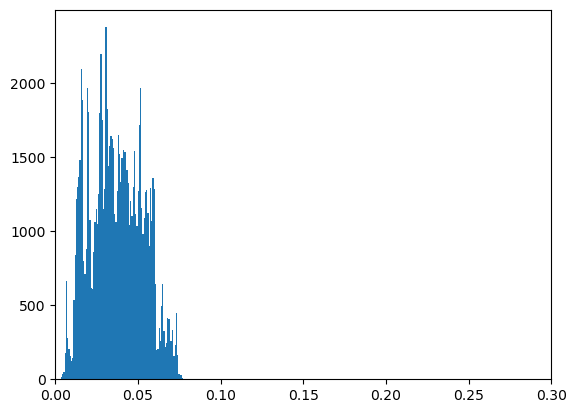

In [6]:
# extract valocities and chunk 
vels = uncond_pre[..., -3:] 
n_chunks = 100
vels = np.array_split(vels, n_chunks, axis=0)

# magnitude of velocity
vels_mag = np.linalg.norm(vels, axis=-1)
print(vels_mag.shape)
vels_mag = np.reshape(vels_mag, (n_chunks, -1))

plt.hist(vels_mag[12], bins=100)
plt.xlim(0, 0.3)
plt.show()

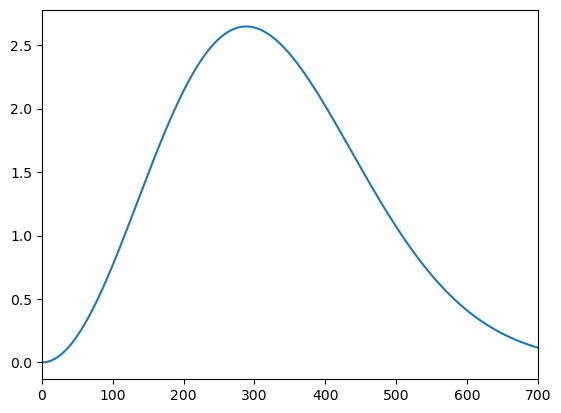

In [8]:
# plot maxwell-boltzmann distribution
v_max = 700
v = np.linspace(0, v_max, 10000)
m = 40 * 1.66053906660e-27
T = temperature
k = 1.38064852e-23
f = v**2 * np.sqrt(m / (2 * np.pi * k * T))**(3/2) * np.exp(-m * v**2 / (2 * k * T))
plt.plot(v, f)
plt.xlim(0, v_max)
plt.show()

In [9]:
uncond_gt = uncond['GT']
print(uncond_gt.shape)

(12800, 1, 64, 9)


In [10]:
xyzs = uncond_gt[..., :3] 
print(np.max(xyzs), np.min(xyzs))

136.81778460716717 -87.82343712679997


(10, 1280, 1, 64)
(100, 1000, 1, 1, 64)


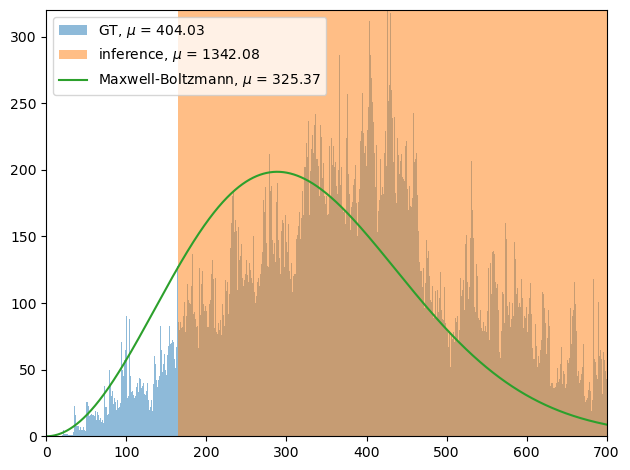

In [9]:
# extract valocities and chunk 
vels_GT = uncond_gt[..., -3:] * 10000
n_chunks = 10
vels_GT = np.array_split(vels_GT, n_chunks, axis=0)

# magnitude of velocity(GT)
vels_mag_GT = np.linalg.norm(vels_GT, axis=-1)
print(vels_mag_GT.shape)
vels_mag_GT = np.reshape(vels_mag_GT, (n_chunks, -1))


vels = uncond_pre[..., -3:] * 10000
vels = np.array_split(vels, n_chunks*10, axis=0)
# magnitude of velocity(inference)
vels_mag = np.linalg.norm(vels, axis=-1)
print(vels_mag.shape)
vels_mag = np.reshape(vels_mag, (n_chunks*10, -1))

vel_to_plot_GT = vels_mag_GT[9]
vel_to_plot = vels_mag[13]


plt.hist(vel_to_plot_GT, bins=1000, alpha=0.5, label=f'GT, $\mu$ = {np.mean(vel_to_plot_GT):.2f}')
plt.hist(vel_to_plot, bins=1000, alpha=0.5, label=f'inference, $\mu$ = {np.mean(vel_to_plot):.2f}')
plt.plot(v, f * 75, label=f'Maxwell-Boltzmann, $\mu$ = {2 * np.sqrt((2 * k * T) / m / np.pi):.2f}')
plt.xlim(0, v_max)
plt.ylim(0, 320)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# check is nan
print(np.isnan(vel_to_plot).any())
print(vel_to_plot.shape)
print("mas and min", np.max(vel_to_plot), np.min(vel_to_plot))
print(vel_to_plot[:100], vel_to_plot_GT[-100:])

False
(64000,)
mas and min 503171.8103833288 164.6578171257987
[ 558.46407164  508.41491039  358.6752808   388.95026961  467.33369888
  590.46528685  627.28728619  492.93732703  400.46115147  266.96697916
  472.10358686  216.55817857  743.96688038  445.34971916  707.75826004
  630.93419709  451.42735352  449.87223718  701.70443381  515.10106272
  462.6642847   367.86337632  620.87386112  449.415157    271.54157513
  265.81902709 1019.5309722   691.58781945  723.49374043  731.01327404
  392.59068745  355.80286409  370.53661851  347.81508794  640.04599204
  598.01908999  384.45577278  702.86609827  447.74103939  378.65099127
  310.24248978  538.53432056  344.47052766  504.98103483  466.43136729
  410.68755562  616.8583327   627.52658841  471.72079467  639.45607328
  715.66444657  471.39578235  485.30829812  502.04357664  405.6794504
  899.85547814  487.49465082  471.87349955  526.85232876  387.17647227
  934.78832285  653.47760384  516.59351567  502.17286703  558.74278124
  508.87374789 

In [11]:
np.shape(uncond_pre), np.shape(uncond_gt)

((100000, 1, 1, 64, 9), (12800, 1, 64, 9))

In [30]:
#uncond_pre = np.mean(uncond_pre, 2)

In [12]:
np.shape(uncond_pre)

(15000, 10, 1, 64, 9)

In [13]:
uncond_pre = np.mean(uncond_pre, 1)
print(uncond_pre.shape)
from tqdm import tqdm

(15000, 1, 64, 9)


In [14]:
d1, d2, d3, d4 = np.shape(uncond_pre) # 512 1 64 9
print(d1, d2, d3, d4)
n_frames_to_draw = 200

for trajs in range(1):
    # if os.path.exists("./results/long_diffusion_test_point_#"+str(idx)+"_traj_#"+str(trajs)+".png"):
    #     continue
    for idx in tqdm(range(200)):
        idx = 12000 + idx * 10
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        if idx < d1:
            for i in range(d3):
                if i == d3 -1:
                    ax.scatter(uncond_gt[idx,0,i,0],uncond_gt[idx,0,i,1],uncond_gt[idx,0,i,2], marker='o', c='black', label="GT")
                else:    
                    ax.scatter(uncond_gt[idx,0,i,0],uncond_gt[idx,0,i,1],uncond_gt[idx,0,i,2], marker='o', c='black')
        for i in range(d3):
            if i == d3 -1:
                ax.scatter(uncond_pre[idx,trajs,0,i,0],uncond_pre[idx,trajs,0,i,1],uncond_pre[idx,trajs,0,i,2], marker='*', c='red', label="Pre")
            else:
                ax.scatter(uncond_pre[idx,trajs,0,i,0],uncond_pre[idx,trajs,0,i,1],uncond_pre[idx,trajs,0,i,2], marker='*', c='red')

        ax.set_title('Test trajectory #'+str(trajs)+',  t = #'+str(idx))
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()
        plt.savefig("./results/extrapolate/long_diffusion_test_point_#"+str(idx)+"_traj_#"+str(trajs)+".png")    
        plt.close()

NameError: name 'uncond_gt' is not defined

In [14]:
# generate gif with saved figs
import imageio
n_frames_to_draw = 200
with imageio.get_writer('./results/long_diffusion_12000_14000_200K.gif', mode='I') as writer:
    for filename in ["./results/extrapolate/long_diffusion_test_point_#"+str(12000 + idx * 10)+"_traj_#0"+".png" \
    for idx in range(n_frames_to_draw)]:
        image = imageio.imread(filename)
        writer.append_data(image)

/tmp/ipykernel_121767/3751838024.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


# GT data

In [3]:
dataset_path = "dataset"
x_tensor=np.load(os.path.join(dataset_path, "input_long_200K.npy"))
x_tensor = np.reshape(x_tensor, (-1,  64, 9))
print(x_tensor.shape)

(100000, 64, 9)


In [34]:
### DONT EXECUTE THIS PART 
import imageio
# Generate figure for the first 10k frames with stride 4
for idx in range(500):
    idx = idx * 100 
    if os.path.exists("./results/GT_figs/diffusion_gt_test_point_#"+str(idx)+".png"):
        continue

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    for i in range(64):
        if i == 63:
            ax.scatter(x_tensor[idx,i,0],x_tensor[idx,i,1],x_tensor[idx,i,2], marker='o', c='black', label="GT")
        else:
            ax.scatter(x_tensor[idx,i,0],x_tensor[idx,i,1],x_tensor[idx,i,2], marker='o', c='black')
    ax.set_title('GT trajectory,  t = #'+str(idx))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    if not os.path.exists("./results/GT_figs"):
        os.makedirs("./results/GT_figs")
    plt.savefig("./results/GT_figs/diffusion_gt_test_point_#"+str(idx)+".png")    
    plt.close()

# generate gif with saved figs
with imageio.get_writer('./results/GT_start.gif', mode='I') as writer:
    for filename in ["./results/GT_figs/diffusion_gt_test_point_#"+str(idx * 100)+".png" for idx in range(500)]:
        image = imageio.imread(filename)
        writer.append_data(image)

/tmp/ipykernel_133456/3005087242.py:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [4]:
x_tensor[0].shape

(64, 9)

In [5]:
def pbc_coord(coord: torch.Tensor, lattice: torch.Tensor) -> torch.Tensor:
    """
    Apply periodic boundary condition to the coordinates.
    Args:
        coord (torch.Tensor): The coordinates to apply PBC to. The shape is (batch_size, num_atoms, 3).
        lattice (torch.Tensor): The lattice vectors. The shape is (batch_size, 3, 3).
    Returns:
        torch.Tensor: The coordinates after applying PBC. The shape is (batch_size, num_atoms, 3).
    """
    # Calculate the fractional coordinates
    fractional_coord = torch.einsum('bji,bni->bnj', torch.inverse(lattice), coord)
    # Apply PBC
    fractional_coord = fractional_coord - torch.floor(fractional_coord)
    # Convert back to Cartesian coordinates
    coord = torch.einsum('bji,bnj->bni', lattice, fractional_coord)
    return coord

def compute_min_distance_pbc_single_cell(
                    coord1: torch.Tensor,  # (batch, num_atom, 3)
                    coord2: torch.Tensor,  # (batch, num_atom, 3)
                    lattice1: torch.Tensor,  # (batch, 3, 3) lattice vectors for coord1 (GT)
                    lattice2: torch.Tensor,  # (batch, 3, 3) optional lattice for coord2 (Pred)
                    mask: torch.Tensor,
                    cutoff: float = 5,
                    eps: float = 1e-6,
                    return_disp: bool = False,
                    num_image_cell: int = 1) -> Tuple[torch.Tensor, torch.Tensor, Optional[torch.Tensor], Optional[torch.Tensor]]:
    
    if lattice1 is None and lattice2 is None:
        return comput_disp(coord1, coord2, mask, cutoff, eps)

    #print("coord shape: ", coord1.shape)
    batch_size, num_atoms, _ = coord1.shape
    # Normalize the coord (move into the unit cell)
    #print('coord before pbc_coord: ', coord)
    #coord = pbc_coord(coord, lattice)
    #print('coord after pbc_coord: ', coord)
    # if self.max_neighbor is not None:
    # Step 1: Generate relative cell displacement vectors
    # num_image_cell:1 -> (3x3x3) shift vectors
    # num_image_cell:3 -> (7x7x7) shift vectors
    # n_img == num_image_cell**3
    # print("lattice and coord shape : ", lattice1.shape, coord1.shape)

    # step 1: Generate relative cell displacement vectors
    shifts = torch.stack(torch.meshgrid(
        torch.arange(-num_image_cell, num_image_cell + 1),  # Neighbor cells in x
        torch.arange(-num_image_cell, num_image_cell + 1),  # Neighbor cells in y
        torch.arange(-num_image_cell, num_image_cell + 1),   # Neighbor cells in z
    indexing="ij"), dim=-1).reshape(-1, 3).type(coord1.dtype).to(coord1.device)  
    # shift = [0,0,0] index
    r_000_index = torch.where(torch.all(shifts == 0, dim=-1))[0].item()
    num_images = shifts.shape[0]
    # Apply lattice vectors to get Cartesian displacements for the 27 neighbor cells
    # The shape should be (batch_size, 27, 3), where lattice has shape (batch_size, 3, 3) and shifts has shape (27, 3)
    # print("shifts shape: ", shifts.shape)
    r_vector_1 = torch.einsum('nj, bji->bni', shifts, lattice1)  # (batch_size, 27, 3)
    r_vector_2 = torch.einsum('nj, bji->bni', shifts, lattice2)
    # print("r_vector shape: ", r_vector.shape)
        
    # Step 2: calculate distance btw original(coord1) and noised coord pbc (coord2_ext)
    # coord1_ext = coord1.unsqueeze(2) + r_vector_1.unsqueeze(1)  # (batch_size, num_atoms, n_img, 3)
    coord1_ext = coord1.unsqueeze(2) + r_vector_1.unsqueeze(1)  # (batch_size, num_atoms, n_img, 3)
    disp_1 = coord1_ext.unsqueeze(2) - coord1.unsqueeze(1).unsqueeze(3)
    coord2_ext = coord2.unsqueeze(2) + r_vector_2.unsqueeze(1)  # (batch_size, num_atoms, n_img, 3)
    disp_2 = coord2_ext.unsqueeze(2) - coord2.unsqueeze(1).unsqueeze(3)
    
    
    self_min_disp = torch.sqrt(torch.sum(disp_1 ** 2, dim=-1))  # (batch_size, num_atoms, num_atoms, n_img)
    
    #print("self min disp shape: ", self_min_disp.shape)

    min_dist, min_idx = torch.min(self_min_disp, dim=-1)  # (batch_size, num_atoms, num_atoms)
    min_disp = torch.gather(disp_1, 3,  min_idx.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, -1, 1, 3))
    
    #return disp
    return min_dist, min_disp, min_idx


device ="cpu" # torch.device("cuda" if torch.cuda.is_available() else "cpu")
cell_vector = torch.tensor([[[21.04, 0.0, 0.0], [0.0, 21.04, 0.0], [0.0, 0.0, 21.04]]], device=device)
coord1 = torch.from_numpy(x_tensor[1000:1002, :, :3]).to(device).float()
coord2 = torch.from_numpy(x_tensor[1000:1002, :, :3]).to(device).float()
min_dist_single_cell, min_disp_single_cell, min_idx_single_cell = \
    compute_min_distance_pbc_single_cell(coord1, coord2, cell_vector, cell_vector, mask=None)
print(min_disp_single_cell.shape)

torch.Size([2, 64, 64, 1, 3])


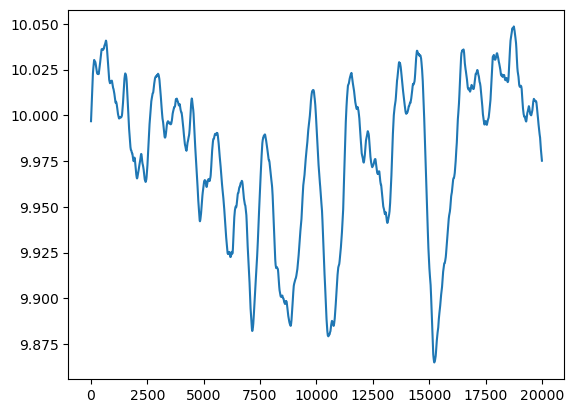

In [6]:
vec_difference = []
for i in range(5000, 25000):
    coord1 = torch.from_numpy(x_tensor[i:i+1, :, :3]).to(device).float()
    coord1 = pbc_coord(coord1, cell_vector)
    coord2 = torch.from_numpy(x_tensor[i:i+1, :, :3]).to(device).float()
    coord2 = pbc_coord(coord2, cell_vector)
    min_dist_single_cell, min_disp_single_cell, min_idx_single_cell = \
        compute_min_distance_pbc_single_cell(coord1, coord2, cell_vector, cell_vector, mask=None)
    vec_difference.append(np.mean(min_dist_single_cell.cpu().detach().numpy()))

plt.plot(vec_difference)

In [68]:
min_dist_single_cell

tensor([[[ 0.0000,  6.4037,  3.8313,  ...,  8.8433, 10.2151, 11.9957],
         [ 6.4037,  0.0000,  8.9623,  ..., 11.9629, 10.6630, 14.6291],
         [ 3.8313,  8.9623,  0.0000,  ...,  5.3643,  6.4464, 10.3749],
         ...,
         [ 8.8433, 11.9629,  5.3643,  ...,  0.0000,  4.6452,  5.4114],
         [10.2151, 10.6630,  6.4464,  ...,  4.6452,  0.0000,  6.9678],
         [11.9957, 14.6291, 10.3749,  ...,  5.4114,  6.9678,  0.0000]]])

In [72]:
torch.sqrt(torch.sum(min_disp_single_cell.squeeze()**2, -1))

tensor([[ 0.0000,  6.4037,  3.8313,  ...,  8.8433, 10.2151, 11.9957],
        [ 6.4037,  0.0000,  8.9623,  ..., 11.9629, 10.6630, 14.6291],
        [ 3.8313,  8.9623,  0.0000,  ...,  5.3643,  6.4464, 10.3749],
        ...,
        [ 8.8433, 11.9629,  5.3643,  ...,  0.0000,  4.6452,  5.4114],
        [10.2151, 10.6630,  6.4464,  ...,  4.6452,  0.0000,  6.9678],
        [11.9957, 14.6291, 10.3749,  ...,  5.4114,  6.9678,  0.0000]])